# Skin Cancer Detection
## by Ablokit Joshi (IIT Kanpur)

### Import Neccesary modules for Data Analysis

In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt

### To save the RAM and time, we will use the pixel coordinates given in hmnist_28_28_RGB.csv. There are 28X28X3 (=2352) pixel coordinates depicting its image shape of (28,28,3).
## Load the HAM10000_metadata.csv and hmnist_28_28_RGB.csv

In [3]:
image_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/hmnist_28_28_RGB.csv')
metadata_df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

## Data Analysis

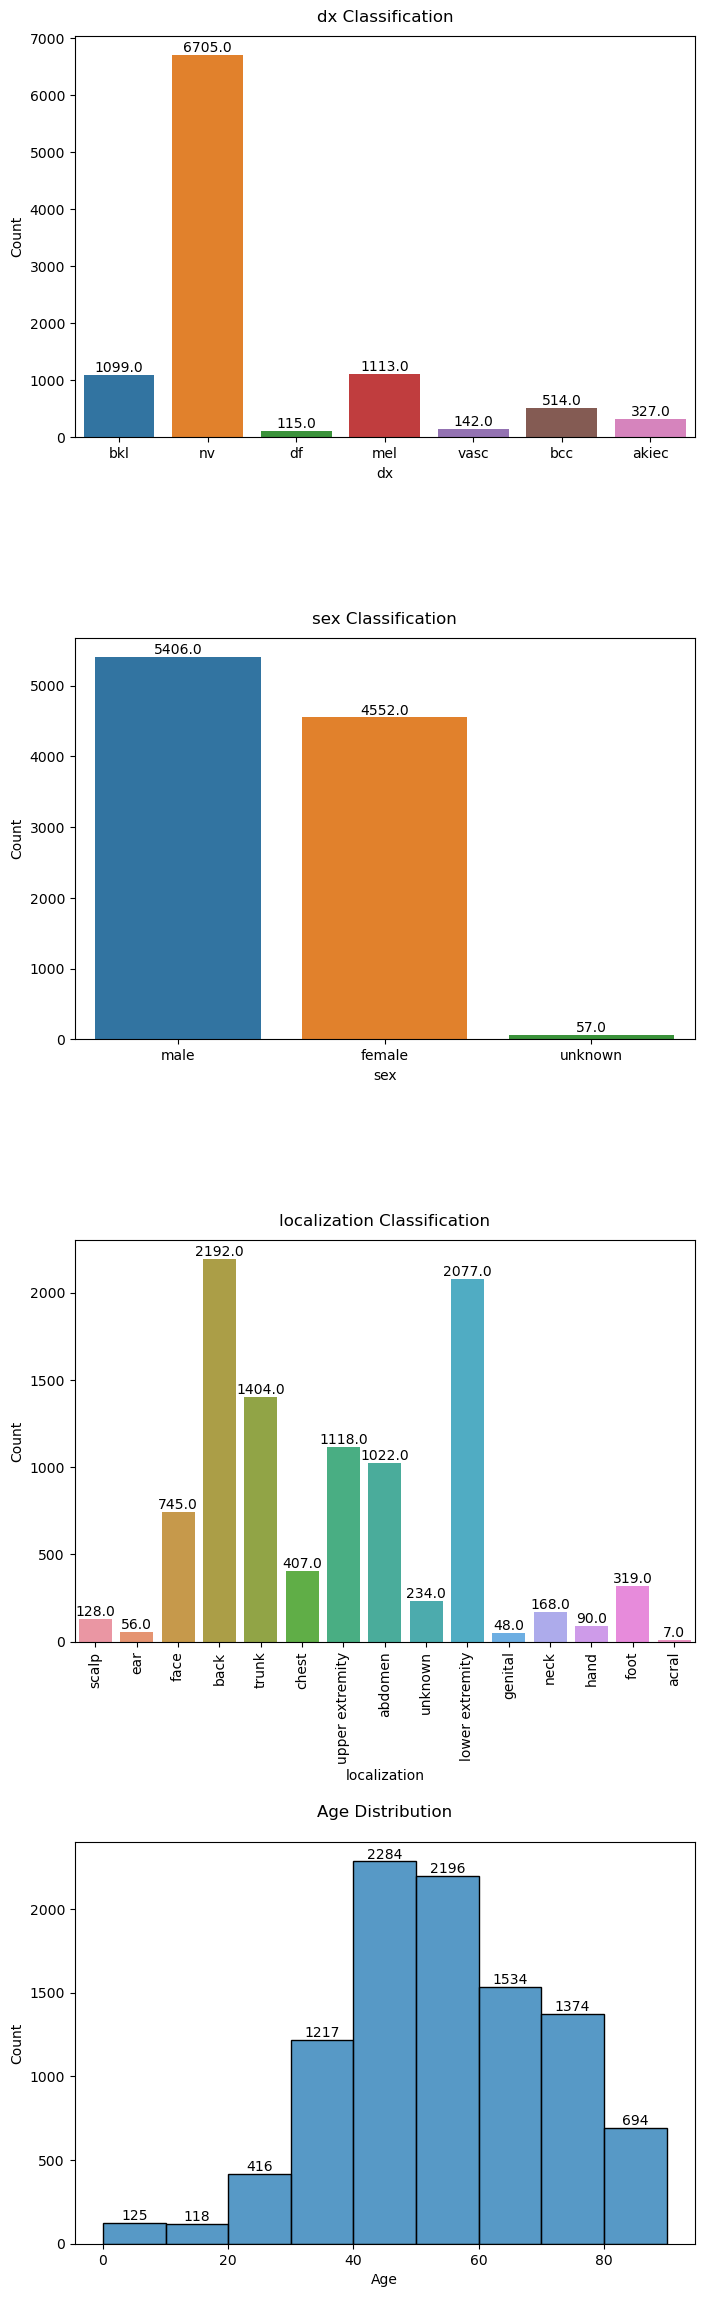

In [4]:

# Plot column-wise classification
columns_to_plot = ['dx', 'sex', 'localization']
fig, axes = plt.subplots(len(columns_to_plot) + 1, 1, figsize=(8, (len(columns_to_plot) + 1) * 6))

for i, column in enumerate(columns_to_plot):
    ax = axes[i]
    sns.countplot(data=metadata_df, x=column, ax=ax)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.set_title(f'{column} Classification',pad=10)
    
    # Remove upper border
    ax.spines['top'].set_visible(False)
    
    # Add value counts annotations
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')
    
    if column == 'localization':  # Rotate x-axis labels for 'localization' column
        ax.tick_params(axis='x', rotation=90)

# Histogram for 'age' with divisions of 10 years
ax = axes[-1]
sns.histplot(data=metadata_df, x='age', bins=range(0, 100, 10), ax=ax)  # Binning with divisions of 10 years
ax.set_xlabel('Age')
ax.set_ylabel('Count')
ax.set_title('Age Distribution\n')

# Add value counts annotations on the histogram bars
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='bottom')

# Adjust subplot parameters and margin distance
plt.subplots_adjust(hspace=0.5, top=1, bottom=0.08)
for ax in axes:
    ax.set_frame_on(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)

plt.show()


## Applying the EfficienttNetb7 model
### Load the libraries required for the model

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.utils import resample
from sklearn.metrics import accuracy_score
from PIL import Image

## Data Preprocessing
### Trimming and Balancing such that each label has 2000 datas

In [6]:
max_count = 2000
balanced_samples = []
class_counts = image_df['label'].value_counts()

for cls, count in class_counts.items():
    if count < max_count:
        # Oversample the minority class
        minority_samples = image_df[image_df['label'] == cls]
        oversampled_samples = resample(minority_samples, replace=True, n_samples=max_count, random_state=42)
        balanced_samples.append(oversampled_samples)
    elif count > max_count:
        # Undersample the majority class
        majority_samples = image_df[image_df['label'] == cls]
        undersampled_samples = resample(majority_samples, replace=False, n_samples=max_count, random_state=42)
        balanced_samples.append(undersampled_samples)
    else:
        balanced_samples.append(image_df[image_df['label'] == cls])

balanced_data = pd.concat(balanced_samples)

### Seperating the pixel and labels as a list

In [7]:
# Extract pixel values and labels
X_pixels = balanced_data.iloc[:, :-1].values  # Exclude the last column (labels)
labels = balanced_data.iloc[:, -1].values

#### Resizing the image from (28,28,3) to (32,32,3)

In [8]:
image_shape = (28, 28, 3)
X_images = X_pixels.reshape(-1, *image_shape)
resized_images = []
for image in X_images:
    # Convert the image array to the appropriate data type
    image = np.uint8(image)
    
    # Create a PIL Image object
    image_pil = Image.fromarray(image)
    
    # Resize the image
    image_pil = image_pil.resize((32, 32))
    
    # Convert the resized image back to a numpy array
    image_resized = np.array(image_pil)
    
    resized_images.append(image_resized)

X_images_resized = np.array(resized_images)


#### Converting the labels into a categorical format

In [9]:
# Convert labels to categorical format
y_labels = to_categorical(labels)

## Model Training
### Randomly splitting the data into 80% Training set and rest 20% to Testing set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X_images_resized, y_labels, test_size=0.2, random_state=42)

### Applying the model

In [12]:
# Load the EfficientNetB7 model (pretrained on ImageNet)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=(32,32,3))

# Add a new classification head on top
x = GlobalAveragePooling2D()(base_model.output)
output = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model and collect history
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test))

258076736/258076736 [==============================] - 1s 0us/step
Epoch 1/10


2023-06-20 07:49:47.999023: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


350/350 [==============================] - 222s 172ms/step - loss: 1.1940 - accuracy: 0.5618 - val_loss: 2.2609 - val_accuracy: 0.5382
Epoch 2/10
350/350 [==============================] - 55s 156ms/step - loss: 0.8640 - accuracy: 0.6939 - val_loss: 1.0572 - val_accuracy: 0.7164
Epoch 3/10
350/350 [==============================] - 55s 157ms/step - loss: 0.6253 - accuracy: 0.7862 - val_loss: 0.7867 - val_accuracy: 0.7154
Epoch 4/10
350/350 [==============================] - 54s 154ms/step - loss: 0.5704 - accuracy: 0.8045 - val_loss: 0.5008 - val_accuracy: 0.8118
Epoch 5/10
350/350 [==============================] - 55s 156ms/step - loss: 0.3559 - accuracy: 0.8779 - val_loss: 0.3483 - val_accuracy: 0.8879
Epoch 6/10
350/350 [==============================] - 54s 155ms/step - loss: 0.2641 - accuracy: 0.9143 - val_loss: 0.2980 - val_accuracy: 0.9089
Epoch 7/10
350/350 [==============================] - 58s 165ms/step - loss: 0.2978 - accuracy: 0.9062 - val_loss: 0.3288 - val_accuracy: 0.

## Model Evaluation
### Plotting the Training and Validation Loss and Accuracy, and also the 7x7 Confusion Matrix

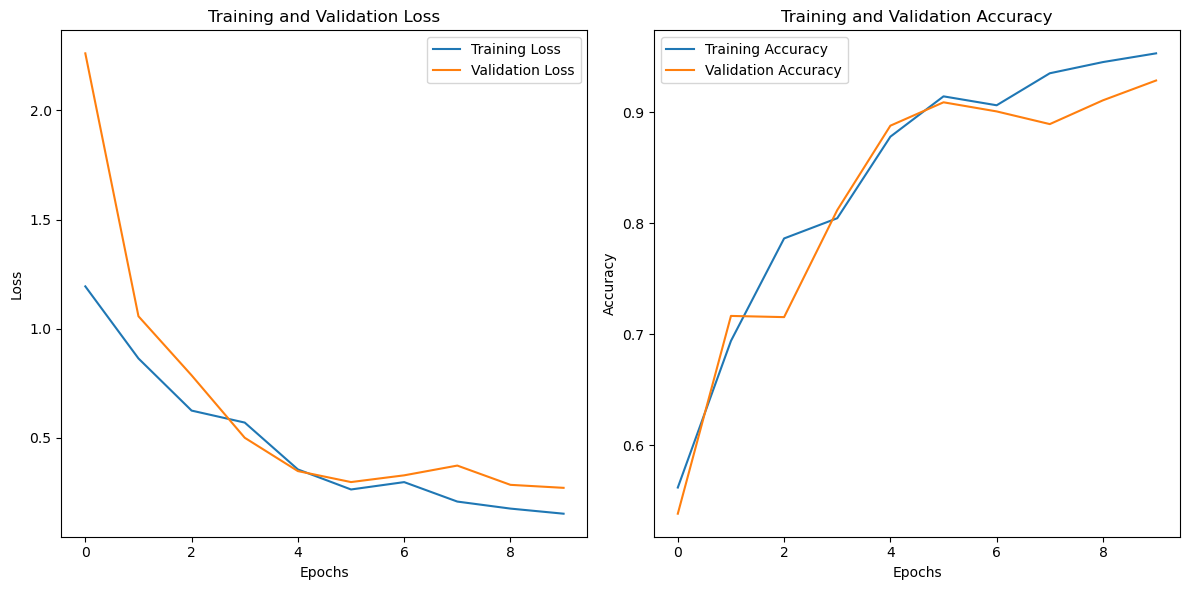

88/88 [==============================] - 2s 27ms/step


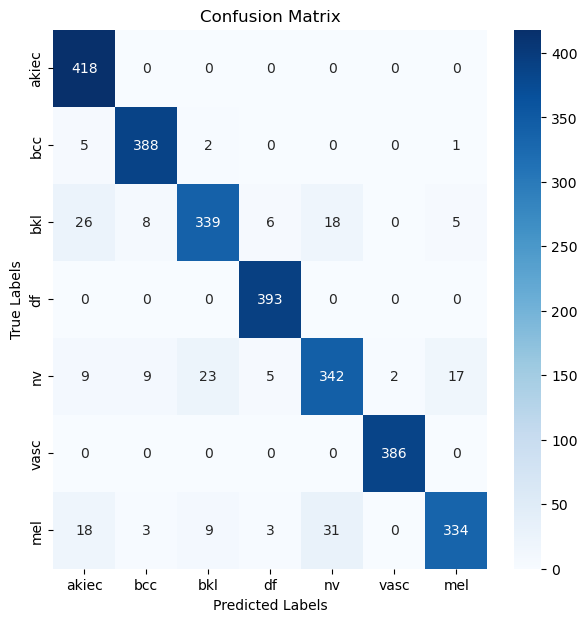

In [28]:
# Plot loss and accuracy curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Generate predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Define the label names
labels = ['akiec', 'bcc', 'bkl', 'df', 'nv', 'vasc', 'mel']


# Generate predictions
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)

# Plot confusion matrix
plt.figure(figsize=(7, 7))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


### Accuracy

In [19]:
accuracy = accuracy_score(y_test_labels, y_pred_labels)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9285714285714286


## Conclusion

### After training the model, I achieved an accuracy of 93% on the testing set. This indicates that the model was able to successfully learn and generalize patterns in the data, achieving a high level of accuracy in predicting the classes.

### The high accuracy achieved by the model demonstrates its effectiveness in classifying the images into their respective categories. This can have valuable applications in various fields, such as medical diagnosis, skin cancer detection, and more.

### Further improvements can be made by exploring different architectures, hyperparameter tuning, and data augmentation techniques to potentially enhance the model's performance even further.

### Overall, this project showcases the potential of utilizing state-of-the-art models like EfficientNetB7 for image classification tasks, providing accurate predictions and opening up avenues for further research and applications.